In [96]:
# Импортируем необходимые библиотеки и загружаем данные из файлов:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [97]:
data = pd.read_csv('Данные.csv', sep = ';')
clients = pd.read_csv('Clients.csv', sep = ';')
region_dict = pd.read_csv('Region_dict.csv', sep = ';')

In [98]:
data

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,28.10.2022
1,100242,191056.0,4151.0,01.08.2022
2,100249,200049.0,5688.0,24.08.2022
3,100258,206161.0,4330.0,09.12.2022
4,100267,190945.0,5488.0,03.08.2022
...,...,...,...,...
37984,297586,NaN,NaN,NaN
37985,297593,179230.0,5755.0,05.09.2022
37986,297595,192530.0,4448.0,27.09.2022
37987,297601,183888.0,1746.0,13.10.2022


In [99]:
region_dict

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир
...,...,...
61,3987,Москва
62,6543,Москва
63,8543,Москва
64,9121,Москва


In [100]:
clients

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,08.06.2022,0,212
1,193942,NaN,0,13
2,226069,11.07.2022,1,54
3,183981,16.06.2022,1,991
4,322530,08.07.2022,0,1015
...,...,...,...,...
55600,193038,09.07.2022,0,1015
55601,244069,08.08.2022,1,991
55602,189084,29.06.2022,1,439
55603,182758,13.06.2022,1,573


In [101]:
# Проверяем таблицы на наличие пустых значений:
data.isnull().sum()

id_order          0
id_client       588
amt_payment    2144
dtime_pay      2161
dtype: int64

In [102]:
clients.isnull().sum()

id_client             0
dtime_ad            249
nflag_test            0
id_trading_point      0
dtype: int64

In [103]:
region_dict.isnull().sum()

id_trading_point    0
city                0
dtype: int64

In [104]:
# Обработка нулловых значений
# Исключим из таблиц все строки, в которых есть нулловые значения:
data = data.dropna()
clients = clients.dropna()
region_dict = region_dict.dropna()
# В данном случае замена нуллов на другие значения нецелесообразна, 
# так как это может исказить результаты анализа.

In [105]:
# Количество торговых точек в каждом городе
merged_data = clients.merge(region_dict, on='id_trading_point')

In [106]:
# merged_data
# count_test = len(merged_data[(merged_data['nflag_test'] == 1) & (merged_data['city']=='Краснодар')& (merged_data['id_trading_point']==1015)])
# count_control = len(merged_data[merged_data['nflag_test'] == 0] & (merged_data['city']=='Краснодар')& (merged_data['id_trading_point']==1015))

# count_test , count_control

In [107]:
# merged_data[(merged_data['city']=='Краснодар')  & (merged_data['nflag_test']==0) & (merged_data['id_trading_point']==1015) ]

In [108]:
# Группируем полученную таблицу по полю city и подсчитаем количество уникальных значений поля id_trading_point в каждой группе:
grouped_data = merged_data.groupby(['city']).agg({'id_trading_point': 'nunique'}).reset_index()
grouped_data.columns = ['city', 'num_trading_points']
grouped_data_sort = grouped_data.sort_values(by='num_trading_points', ascending=False)

In [109]:
# Краснодар 4
# Новосибирск 6

In [110]:
#  grouped_data_sort

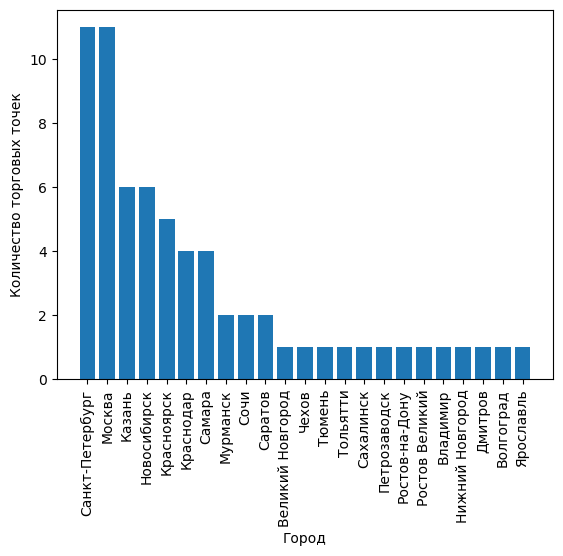

In [111]:
# Построим гистограмму распределения количества торговых точек в каждом городе:
plt.bar(grouped_data_sort['city'], grouped_data_sort['num_trading_points'])
plt.xticks(rotation=90)
plt.xlabel('Город')
plt.ylabel('Количество торговых точек')
plt.show()


In [112]:
# Вычисление суммы платежей на каждого клиента:
payments_sum = data.groupby(['id_client']).agg({'amt_payment':'sum'}).reset_index()
payments_sum.columns = ['id_client', 'total_payments']
payments_sum

,id_client,total_payments
0,178561.0,3052.0
1,178562.0,2439.0
2,178563.0,768.0
3,178565.0,958.0
4,178566.0,5474.0
...,...,...
28595,209630.0,6927.0
28596,209631.0,2090.0
28597,209632.0,2775.0
28598,209633.0,1673.0


In [113]:
# Соединение таблиц:
merged_data = clients.merge(payments_sum, on='id_client', how='left')

In [114]:
#  Заполнение нулями сумм покупок тех клиентов, которые их не совершали:
merged_data['total_payments'] = merged_data['total_payments'].fillna(0)

In [115]:
# Подтягивание города к каждой торговой точке:
merged_data = merged_data.merge(region_dict[['id_trading_point', 'city']], on='id_trading_point', how='left')

In [116]:
# Создание поля флага платежа
merged_data['payment_flag'] = np.where(merged_data['total_payments'] > 0, 1, 0)

In [117]:
from scipy.stats import ttest_ind

r1 = merged_data[(merged_data['nflag_test']==0)]['payment_flag']
r2 = merged_data[(merged_data['nflag_test']==1)]['payment_flag']

def test_calc(r1, r2, alpha=0.05):
    t_stat, p_value = ttest_ind(r1, r2)
    if p_value < alpha:
        print("Существует статистически значимая разница между средними выборок (p_value={})".format(p_value))
    else:
        print("Нет статистически значимой разницы между средними выборок (p_value={})".format(p_value))

test_calc(r1,r2),
ttest_ind(r1, r2)

Существует статистически значимая разница между средними выборок (p_value=1.811489847070908e-07)


Ttest_indResult(statistic=-5.21837498954176, pvalue=1.811489847070908e-07)

In [118]:
from scipy.stats import mannwhitneyu

r1 = merged_data[(merged_data['nflag_test']==0)]['payment_flag']
r2 = merged_data[(merged_data['nflag_test']==1)]['payment_flag']

def mann_whitney_func(r1, r2, alpha=0.05):
    stat, p_value = mannwhitneyu(r1, r2, alternative='two-sided')
    if p_value < alpha:
        print("Существует статистически значимая разница между выборками (p_value={})".format(p_value))
    else:
        print("Нет статистически значимой разницы между выборками (p_value={})".format(p_value))

mann_whitney_func(r1,r2),
mannwhitneyu(r1, r2)

Существует статистически значимая разница между выборками (p_value=1.8170820747299213e-07)


MannwhitneyuResult(statistic=372567163.0, pvalue=1.8170820747299213e-07)

In [119]:
# merged_data

In [120]:
# Список торговых точек, в которых не было заплачено ни одного рубля ни одним клиентом.
empty_points = []
for point in merged_data['id_trading_point'].unique():
    temp_df = merged_data[merged_data['id_trading_point'] == point]
    if temp_df['total_payments'].sum() == 0:
        empty_points.append(point)

In [121]:
print(empty_points)

[26, 7, 23, 4, 1, 13]


In [122]:
# Список торговых точек, в которых пустует или контрольная, или тестовая группа.
empty_groups = []
for point in merged_data['id_trading_point'].unique():
    temp_df = merged_data[merged_data['id_trading_point'] == point]
    if temp_df['total_payments'].nunique() == 0:
        empty_groups.append(point)

In [123]:
# Удалим все торговые точки, которые были найдены в списках «empty_points» и «empty_groups».
merged_data = merged_data[~merged_data['id_trading_point'].isin(empty_points)]
merged_data = merged_data[~merged_data['id_trading_point'].isin(empty_groups)]

<Axes: xlabel='total_payments', ylabel='Count'>

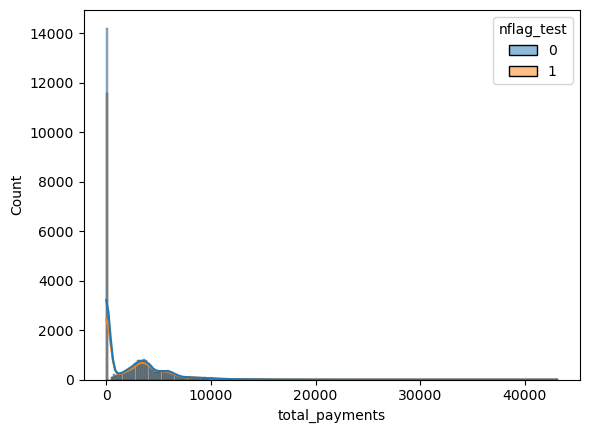

In [124]:
# Гистограмма платежей, на которой различными цветами изображены группы “тест” и “контроль”. 
import seaborn as sns

sns.histplot(data=merged_data, x='total_payments', hue='nflag_test', kde=True)

In [125]:
merged_data['total_payments'] = pd.to_numeric(merged_data['total_payments'])
merged_data['nflag_test'] = pd.to_numeric(merged_data['nflag_test'])

In [126]:
# merged_data

In [127]:
# 5.3
r1 = merged_data[(merged_data['nflag_test']==0)]['total_payments']
r2 = merged_data[(merged_data['nflag_test']==1)]['total_payments']

test_calc(r1,r2)

Существует статистически значимая разница между средними выборок (p_value=2.0036456211777613e-12)


In [128]:
# 5.4
r1 = merged_data[(merged_data['nflag_test']==0)]['payment_flag']
r2 = merged_data[(merged_data['nflag_test']==1)]['payment_flag']

test_calc(r1,r2)

Существует статистически значимая разница между средними выборок (p_value=1.3336941671404502e-09)


In [129]:
# 5.5
r1 = merged_data[(merged_data['nflag_test']==0)]['payment_flag']
r2 = merged_data[(merged_data['nflag_test']==1)]['payment_flag']

mann_whitney_func(r1,r2)

Существует статистически значимая разница между выборками (p_value=1.341555646122262e-09)


In [130]:
print(region_dict['city'].unique())

['Петрозаводск' 'Дмитров' 'Чехов' 'Ростов Великий' 'Владимир'
 'Нижний Новгород' 'Тюмень' 'Великий Новгород' 'Ростов-на-Дону' 'Самара'
 'Ярославль' 'Мурманск' 'Волгоград' 'Сахалинск' 'Сочи' 'Саратов'
 'Тольятти' 'Санкт-Петербург' 'Красноярск' 'Новосибирск' 'Казань' 'Москва'
 'Краснодар']


In [131]:
# Повторим аналитику из пункта 5 в отношении Москвы.

In [132]:
moscow_data = merged_data[merged_data['city'] == 'Москва']

In [133]:
r1 = moscow_data[(moscow_data['nflag_test']==0)]['payment_flag']
r2 = moscow_data[(moscow_data['nflag_test']==1)]['payment_flag']

test_calc(r1,r2)
mann_whitney_func(r1,r2)

Существует статистически значимая разница между средними выборок (p_value=6.194689260032594e-10)
Существует статистически значимая разница между выборками (p_value=6.370381156613038e-10)


In [135]:
# Повторим аналитику из пункта 5 в отношении Санкт-Петербурга.

In [136]:
spb_data = merged_data[merged_data['city'] == 'Санкт-Петербург']

In [137]:
r1 = spb_data[(spb_data['nflag_test']==0)]['payment_flag']
r2 = spb_data[(spb_data['nflag_test']==1)]['payment_flag']

test_calc(r1,r2)
mann_whitney_func(r1,r2)

Существует статистически значимая разница между средними выборок (p_value=1.065825659919673e-20)
Существует статистически значимая разница между выборками (p_value=1.3118606823466691e-20)


In [139]:
# Запустим цикл по оставшимся городам. Проведем такой же анализ.

In [140]:
from scipy import stats

for city in merged_data['city'].unique():
    if city not in ['Москва', 'Санкт-Петербург']:
        city_data = merged_data[merged_data['city'] == city]
        ttest, pvalue_ttest = stats.ttest_ind(city_data[city_data['nflag_test'] == 1]['total_payments'], city_data[city_data['nflag_test'] == 0]['total_payments'])
        mannwhitneyu_1 = stats.mannwhitneyu(city_data[city_data['nflag_test'] == 1]['total_payments'], city_data[city_data['nflag_test'] == 0]['total_payments'])
        print('###',city,'###')
        print('ttest',ttest)
        print('pvalue',pvalue_ttest)
        print(mannwhitneyu_1)
        print('')

### Красноярск ###
ttest 0.12000608689929208
pvalue 0.9044823881233125
MannwhitneyuResult(statistic=4393882.0, pvalue=0.8770469886251647)

### Мурманск ###
ttest 0.06902498862889384
pvalue 0.9449762446327565
MannwhitneyuResult(statistic=569507.5, pvalue=0.5434251528583327)

### Казань ###
ttest 1.0655273408818378
pvalue 0.286688049247618
MannwhitneyuResult(statistic=3263925.0, pvalue=0.37726004167062477)

### Краснодар ###
ttest 1.1499685634233776
pvalue 0.2502147737162163
MannwhitneyuResult(statistic=1951099.0, pvalue=0.23094367751359168)

### Новосибирск ###
ttest 3.4631128428326985
pvalue 0.0005382801056204593
MannwhitneyuResult(statistic=3426781.0, pvalue=2.3393918439205915e-05)

### Ярославль ###
ttest -20.320571854948493
pvalue 4.9011004367076225e-78
MannwhitneyuResult(statistic=65726.0, pvalue=7.664284737629746e-91)

### Саратов ###
ttest -0.10516947629572568
pvalue 0.9162512798549167
MannwhitneyuResult(statistic=565440.5, pvalue=0.7833257779753139)

### Тольятти ###
ttest 1.504

In [141]:
# city_data

In [143]:
# Создаем пустой датафрейм
results_df = pd.DataFrame(columns=['city', 'id_trading_point', 'count_test', 'count_control', 'count_all', 'percent_count',
                                   'avg_payment_test', 'avg_payment_control', 'diff', 'sigma_test', 'sigma_control', 
                                   'ttest', 'pvalue_ttest', 'label'])

In [144]:
# Запускаем цикл по всем городам и торговым точкам


for city in merged_data['city'].unique():
        city_data = merged_data[merged_data['city'] == city]
        for tp in city_data['id_trading_point'].unique():
            tp_data = city_data[city_data['id_trading_point'] == tp]
            count_test = len(tp_data[tp_data['nflag_test'] == 1])
            count_control = len(tp_data[tp_data['nflag_test'] == 0])
            count_all = count_test + count_control
            percent_count = count_all / len(city_data)
            avg_payment_test = tp_data[tp_data['nflag_test'] == 1]['total_payments'].mean()
            avg_payment_control = tp_data[tp_data['nflag_test'] == 0]['total_payments'].mean()
            diff = avg_payment_test - avg_payment_control
            sigma_test = tp_data[tp_data['nflag_test'] == 1]['total_payments'].std()
            sigma_control = tp_data[tp_data['nflag_test'] == 0]['total_payments'].std()
            ttest, pvalue_ttest = stats.ttest_ind(tp_data[tp_data['nflag_test'] == 1]['total_payments'], tp_data[tp_data['nflag_test'] == 0]['total_payments'])
            if pvalue_ttest < 0.05:
                if diff > 0:
                    label = 'positive'
                else:
                    label = 'negative'
            else:
                label = 'neutral'
            results_df.loc[len(results_df)] = [city, tp, count_test, count_control, count_all, percent_count,
                                               avg_payment_test, avg_payment_control, diff, sigma_test, sigma_control,
                                               ttest, pvalue_ttest, label]

In [145]:
# results_df[results_df['diff'].isna()]

In [146]:
# merged_data[(merged_data['city']=='Новосибирск')  & (merged_data['nflag_test']==1) & (merged_data['total_payments'] > 0) ]

In [147]:
# merged_data[(merged_data['city']=='Новосибирск') ].groupby('nflag_test','id_trading_point').agg({'total_payments':'sum','nflag_test':'count' })

In [148]:
# Выгрузим полученные результаты в Excel. 
# Разнесем результаты по трем разным листам в зависимости от лейбла.
# with pd.ExcelWriter('results.xlsx') as writer:
#     results_df[results_df['label'] == 'positive'].to_excel(writer, sheet_name='Positive', index=False)
#     results_df[results_df['label'] == 'negative'].to_excel(writer, sheet_name='Negative', index=False)
#     results_df[results_df['label'] == 'neutral'].to_excel(writer, sheet_name='Neutral', index=False)